# <center>Computing the count rate of observing HAT-P-11 with the APO 3.5m telescope using ``synphot``</center>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
from synphot.models import BlackBody1D, BlackBodyNorm1D
from synphot.spectrum import SourceSpectrum

### Compute the photon flux (of HAT-P-11)

<p>To generate the <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html">source spectrum</a>, we approximate it as a blackbody using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/api/synphot.models.BlackBody1D.html#synphot.models.BlackBody1D">BlackBody1D model</a> (for other available profiles, <a href="https://synphot.readthedocs.io/en/latest/synphot/overview.html#synphot-and-astropy-models">see here</a>).</p>

<p>Alternatively, if you already have a spectrum of a star, you can use <tt>synphot</tt> to load it with <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SourceSpectrum.html#synphot.spectrum.SourceSpectrum.from_file">SourceSpectrum.from_file()</a>.</p>

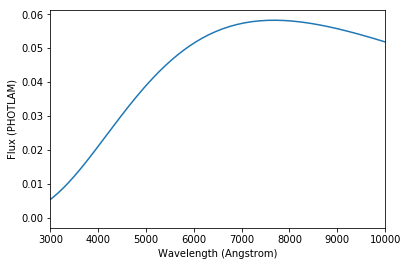

In [2]:
T_eff = 4780  # temperature of hatp11[K]

# Use synphot.models and synphot.spectrum module to generate a blackbody spectrum
photlam_hatp11 = SourceSpectrum(BlackBody1D, temperature=T_eff)  # in photon s-1 cm^-2 AA^-1

# Compute the flux at Earth from the luminosity 
R = 0.683 * u.R_sun  # radius in solar units
d = (123 * u.lyr).to(u.R_sun)  # distance to HATP11 in solar radii
photlam_hatp11 = photlam_hatp11 * (R / d) ** 2

photlam_hatp11.plot(left=3000, right=10000)

### Simulate the observation with a specific instrument

<p>Let's observe HAT-P-11 with the Agile instrument on APO's 3.5m telescope, whose net wavelength transmission can be downloaded from <a href="https://www.apo.nmsu.edu/arc35m/Instruments/AGILE/Anjum/wav.dat">APO's website</a>. We will use this to construct a bandpass specific to Agile.</p><p>To construct a bandpass from a file with <tt>synphot</tt>, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a>:</p>

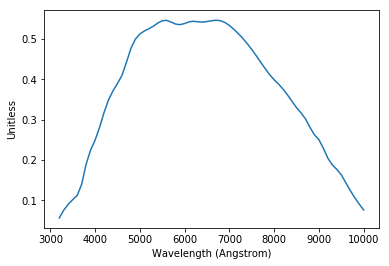

In [3]:
from synphot import SpectralElement

agile = SpectralElement.from_file('agile.dat', wave_unit="nm")
agile.plot()

Convolve the source spectrum with this bandpass using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html">Observation</a>:

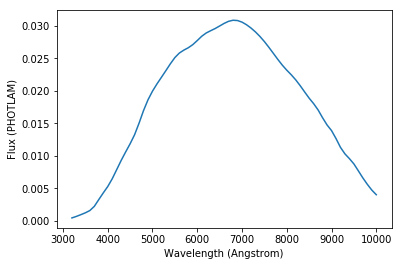

In [4]:
from synphot import Observation
import numpy as np

obs = Observation(photlam_hatp11, agile)
obs.plot()

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate">countrate()</a> method: 

In [5]:
r = 3.5 / 2 * u.m  # radius of 3.5m ARC telescope at APO
area = np.pi * r.to(u.cm) ** 2

cr = obs.countrate(area=area)
print(cr)

11852206.200075638 ct / s


How many photons can be expected in a 10 second exposure?

In [6]:
cr * 10 * u.s

<Quantity 1.18522062e+08 ct>

# <center>Similar example, this time observing TRAPPIST-1 with a different instrument</center>

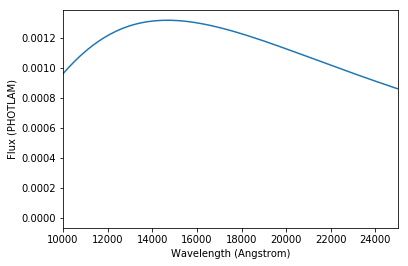

In [91]:
T_eff = 2500  # temperature of trappist-1 [K]

photlam_trappist1 = SourceSpectrum(BlackBody1D, temperature=T_eff)  # photon s-1 cm^-2 AA^-1

# Compute the flux at Earth from the luminosity 
R = 0.121 * u.R_sun  # radius of trappist-1 in solar units
d = (39.6 * u.lyr).to(u.R_sun)  # distance to trappist-1 in solar radii
photlam_trappist1 = photlam_trappist1 * (R / d) ** 2

photlam_trappist1.plot(left=10000, right=25000)

This time we will observe with the standard J, H, and K filters using the <a href="https://www.apo.nmsu.edu/arc35m/Instruments/NICFPS/">NICFPS instrument</a> on APO's 3.5m telescope. ``synphot`` provides a few <a href="https://synphot.readthedocs.io/en/latest/synphot/bandpass.html#synphot-predefined-filter">pre-defined fliters</a> which you can use to construct a bandpass using SpectralElement<a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum.SpectralElement.from_filter">.from_filter()</a>, as long as you have followed all of the instructions in <a href="https://synphot.readthedocs.io/en/latest/index.html#synphot-installation-setup">the installation and setup</a>.

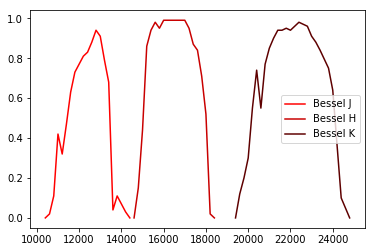

In [48]:
J = SpectralElement.from_filter('bessel_j')
H = SpectralElement.from_filter('bessel_h')
K = SpectralElement.from_filter('bessel_k')

plt.plot(J.waveset, J(J.waveset), '#FF0000', \
         H.waveset, H(H.waveset), '#C90000', \
         K.waveset, K(K.waveset), '#5E0000')
plt.legend([J.meta['header']['descrip'], H.meta['header']['descrip'],  K.meta['header']['descrip']])

Convolve the spectrum with the bandpasses:

In [77]:
obs_J = Observation(photlam_trappist1, J)
obs_H = Observation(photlam_trappist1, H)
obs_K = Observation(photlam_trappist1, K)

Compute the count rates using the same telescope (i.e. same collecting area). How many photons can be expected in a 1 minute exposure in each band?:

In [90]:
bands = ['J', 'H', 'K']

crs = [obs_J.countrate(area=area), 
       obs_H.countrate(area=area), 
       obs_K.countrate(area=area)]

for i in range(len(bands)):
    print("Count rate in", bands[i], "band =", crs[i],
          ", 1 min exposure gives ", crs[i] * 60 * u.s)

Count rate in J band = 227103.4881269894 ct / s , 1 min exposure gives  13626209.287619364 ct
Count rate in H band = 350075.02763794095 ct / s , 1 min exposure gives  21004501.658276457 ct
Count rate in K band = 349886.00662525 ct / s , 1 min exposure gives  20993160.397515 ct
